# Regression Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df=pd.read_csv('resfood.csv')
df

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300
...,...,...,...,...,...,...,...,...,...
12685,QUICK BITES,13228,"North Indian, Burger, Kebab","12noon – 12midnight (Mon, Tue, Wed, Thu, Sun)...",Hyderabad,Gachibowli,3.8,546 votes,500
12686,"CASUAL DINING,BAR",9686,"Goan, Continental","12noon – 1am (Mon-Fri),11am – 5pm, 7pm – 1am...",Mumbai,Bandra Kurla Complex,4.3,1214 votes,1800
12687,LOUNGE,11133,"Finger Food, Continental, Asian, Chinese",12noon – 12:30AM (Mon-Sun),Navi Mumbai,Vashi,4,608 votes,1300
12688,CASUAL DINING,6134,"North Indian, South Indian, Chinese, Street Food",6am – 10:45pm (Mon-Sun),Chennai,Maduravoyal,3.5,32 votes,400


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12690 entries, 0 to 12689
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TITLE          12690 non-null  object
 1   RESTAURANT_ID  12690 non-null  int64 
 2   CUISINES       12690 non-null  object
 3   TIME           12690 non-null  object
 4   CITY           12578 non-null  object
 5   LOCALITY       12592 non-null  object
 6   RATING         12688 non-null  object
 7   VOTES          11486 non-null  object
 8   COST           12690 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 892.4+ KB


In [4]:
df.isnull().sum()

TITLE               0
RESTAURANT_ID       0
CUISINES            0
TIME                0
CITY              112
LOCALITY           98
RATING              2
VOTES            1204
COST                0
dtype: int64

In [5]:
#handling missing data and all three features are categorical in nature so using fillna method with most frequent.
df['CITY'].fillna(df['CITY'].mode()[0], inplace = True)
df['VOTES'].fillna(df['VOTES'].mode()[0], inplace = True)
df['LOCALITY'].fillna(df['LOCALITY'].mode()[0], inplace = True)
df['RATING'].fillna(df['RATING'].mode()[0], inplace = True)

In [6]:
df.isnull().sum()

TITLE            0
RESTAURANT_ID    0
CUISINES         0
TIME             0
CITY             0
LOCALITY         0
RATING           0
VOTES            0
COST             0
dtype: int64

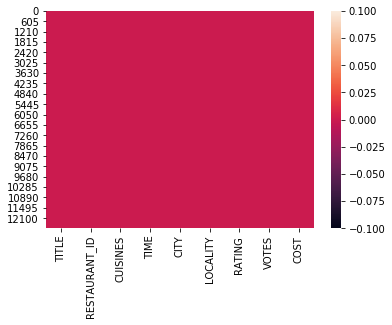

In [7]:
sns.heatmap(df.isnull())
plt.show()

In [8]:
df['VOTES'] = df['VOTES'].replace({'votes':''}, regex = True)
df['VOTES']=df['VOTES'].astype(dtype='int32')
df.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165,300


In [9]:
cf=[]
nf=[] 
for fea in df.columns:
    if df[fea].dtype == 'O':
            cf.append(fea)
    else:
            nf.append(fea)
print(cf)
print('\n',nf)

['TITLE', 'CUISINES', 'TIME', 'CITY', 'LOCALITY', 'RATING']

 ['RESTAURANT_ID', 'VOTES', 'COST']


In [10]:
print('No of numerical features: ',len(nf))
print('No of categorical features: ',len(cf))

No of numerical features:  3
No of categorical features:  6


In [11]:
for col in cf:
    print(df[col].value_counts(),'\n') 

QUICK BITES                    4218
CASUAL DINING                  3652
None                           1003
CAFÉ                            607
DESSERT PARLOR                  382
                               ... 
CAFÉ,FINE DINING                  1
BEVERAGE SHOP,FOOD COURT          1
BEVERAGE SHOP,CASUAL DINING       1
MEAT SHOP                         1
CONFECTIONERY,QUICK BITES         1
Name: TITLE, Length: 113, dtype: int64 

South Indian                                  532
North Indian                                  526
North Indian, Chinese                         501
Fast Food                                     286
Chinese                                       167
                                             ... 
South Indian, Juices                            1
North Indian, European, Mediterranean, BBQ      1
Modern Indian, European                         1
Biryani, Hyderabadi, Kebab                      1
Continental, American, Italian, Salad           1
Name: CUISINE

In [12]:
df['COST'] = df['COST'].astype(float)

# Statistics Summary

In [13]:
df.describe()

,RESTAURANT_ID,VOTES,COST
count,12690.000000,12690.000000,12690.000000
mean,7759.134121,380.405753,655.252246
std,4504.874150,809.110447,627.003540
min,0.000000,4.000000,20.000000
25%,3863.250000,44.000000,300.000000
50%,7740.000000,132.000000,500.000000
75%,11688.750000,405.000000,800.000000
max,15573.000000,41186.000000,14000.000000


In [14]:
df.describe(include = ['O'])

,TITLE,CUISINES,TIME,CITY,LOCALITY,RATING
count,12690,12690,12690,12690,12690,12690
unique,113,4155,2689,359,1416,32
top,QUICK BITES,South Indian,11am – 11pm (Mon-Sun),Chennai,Gachibowli,3.9
freq,4218,532,1415,2286,264,1240


In [15]:
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes

In [16]:
df.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,31,9438,2627,739,320,285,17,49,1200.0
1,33,13198,289,1885,67,1046,23,30,1500.0
2,31,10915,2976,661,67,1101,19,221,800.0
3,95,6346,4130,275,222,136,22,24,800.0
4,50,15387,1766,615,222,620,19,165,300.0


# Data visualisation

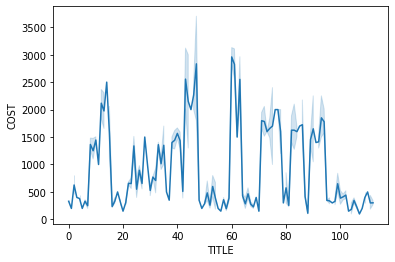

In [17]:
#bivariate analysis
sns.lineplot(x='TITLE',y='COST',data=df) 
plt.show()

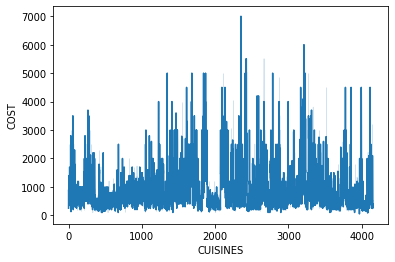

In [18]:
sns.lineplot(x='CUISINES',y='COST',data=df) 
plt.show()

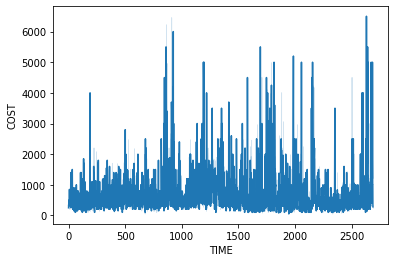

In [19]:
sns.lineplot(x='TIME',y='COST',data=df) 
plt.show()

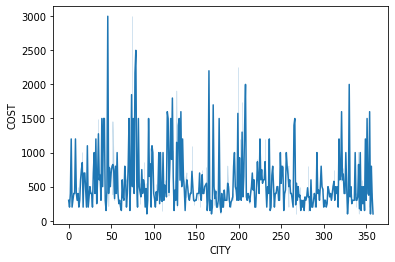

In [20]:
sns.lineplot(x='CITY',y='COST',data=df) 
plt.show()

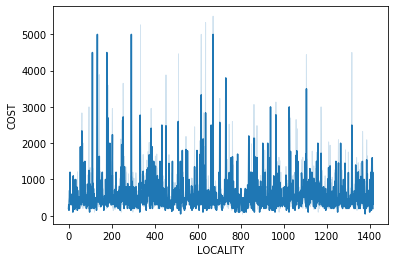

In [21]:
sns.lineplot(x='LOCALITY',y='COST',data=df) 
plt.show()

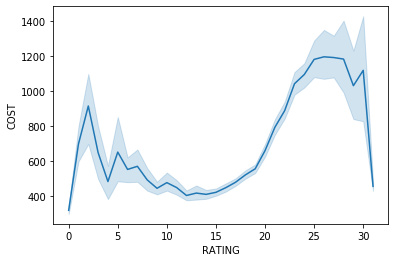

In [22]:
sns.lineplot(x='RATING',y='COST',data=df) 
plt.show()

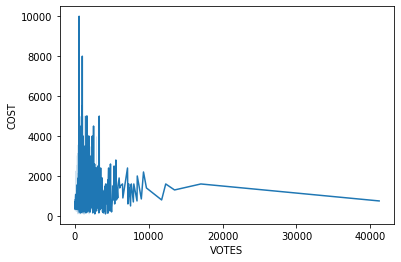

In [23]:
sns.lineplot(x='VOTES',y='COST',data=df) 
plt.show()

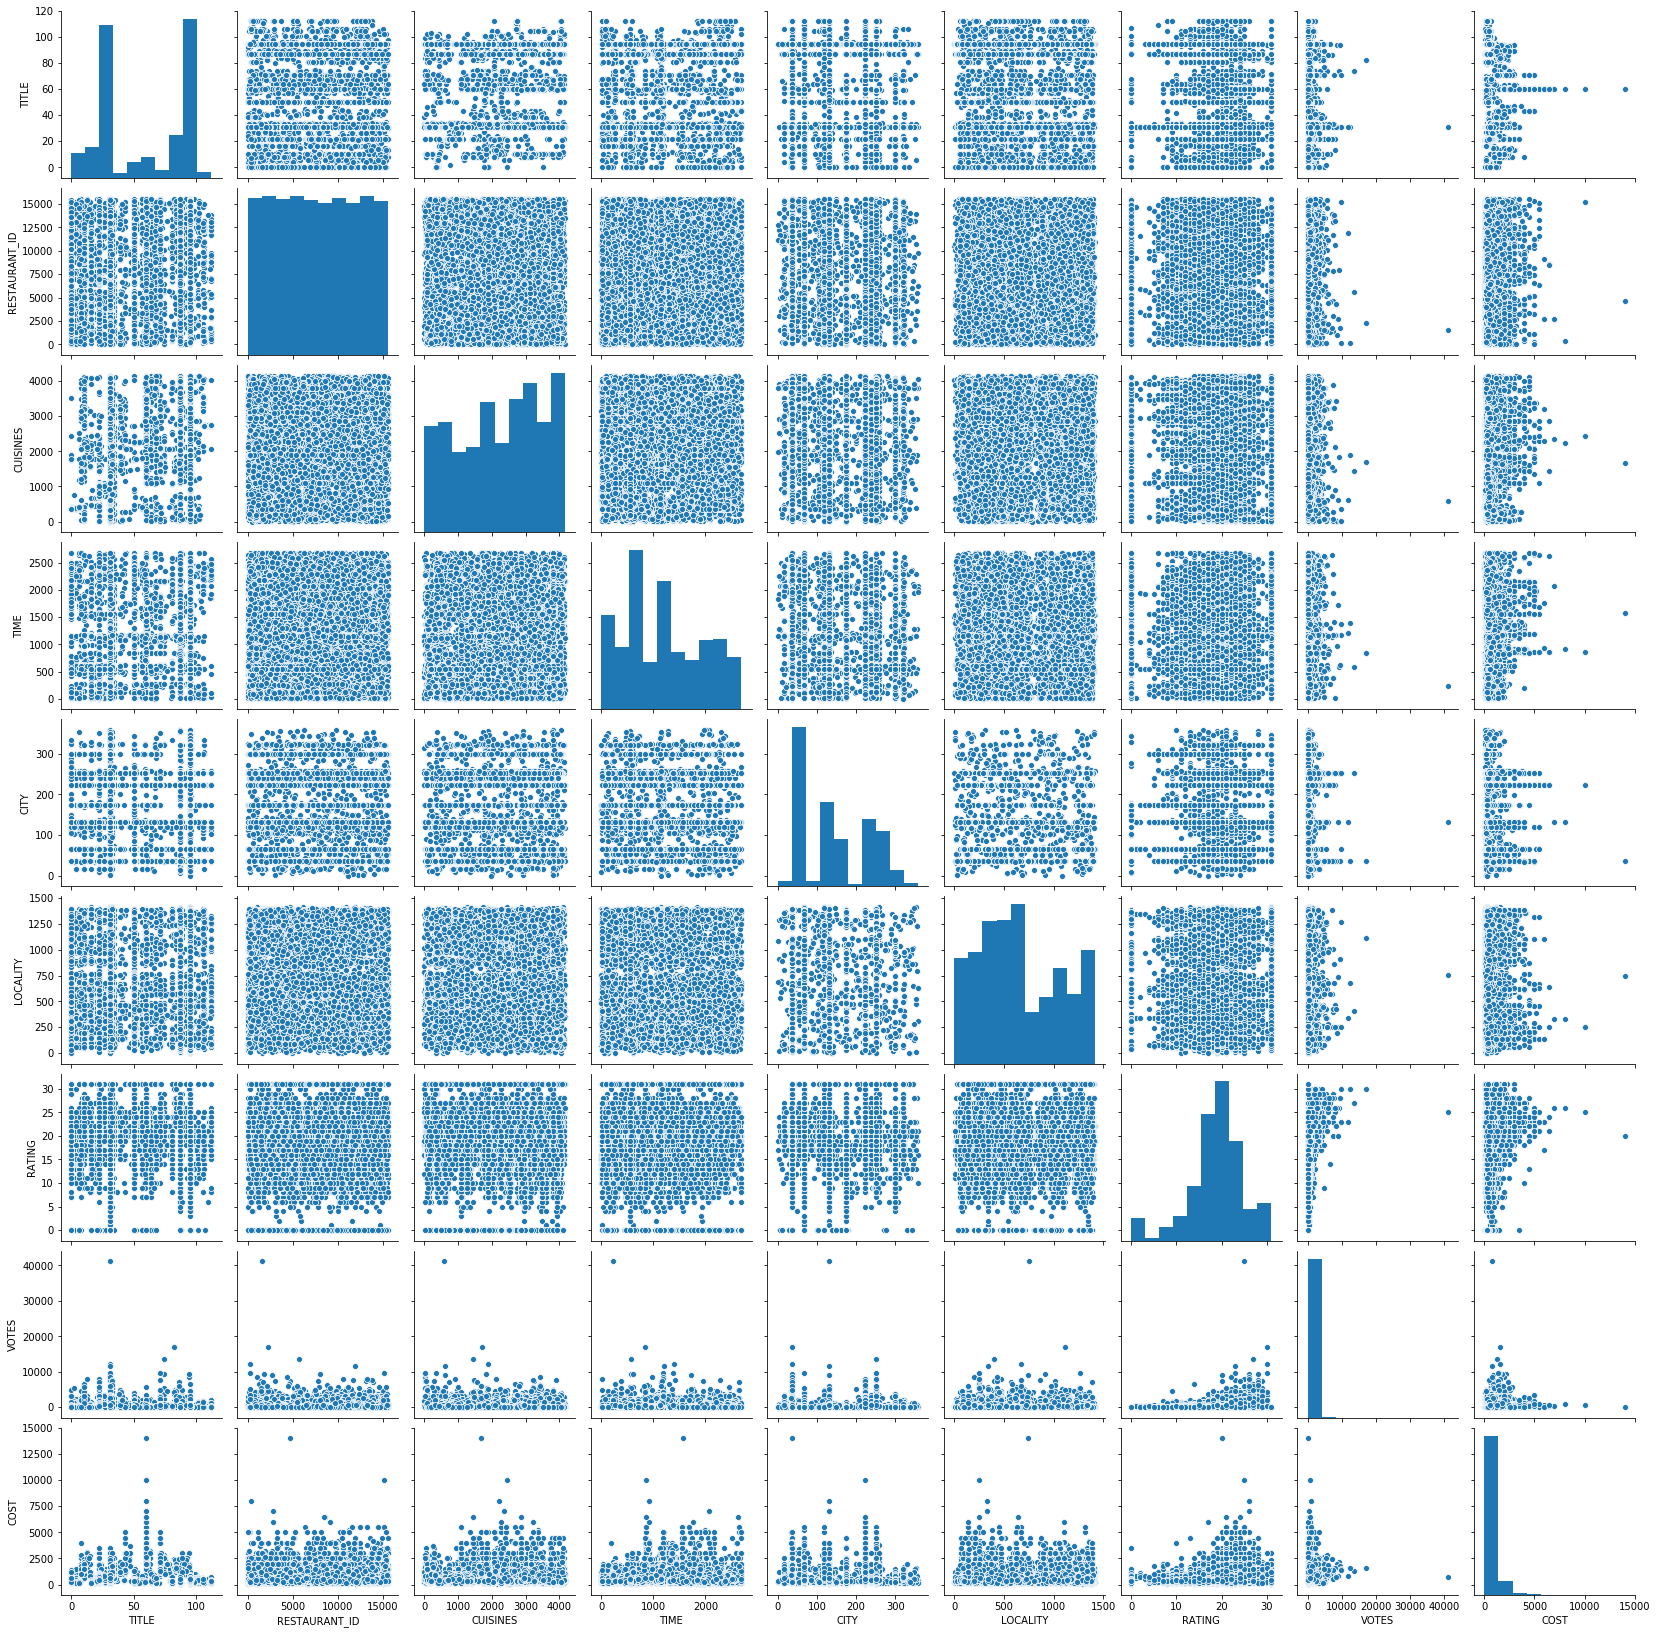

In [24]:
sns.pairplot(data=df) 
plt.show()

In [25]:
#correlation matrix
df.corr()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
TITLE,1.000000,0.002487,0.244866,0.053914,-0.016281,0.026625,-0.039748,-0.132956,-0.263581
RESTAURANT_ID,0.002487,1.000000,0.056239,0.008157,0.005112,-0.004216,0.032441,0.000403,0.040710
CUISINES,0.244866,0.056239,1.000000,0.104741,0.023931,0.016511,-0.038163,-0.035323,-0.014078
TIME,0.053914,0.008157,0.104741,1.000000,-0.011372,-0.008068,-0.035337,-0.016872,0.018248
CITY,-0.016281,0.005112,0.023931,-0.011372,1.000000,0.043076,0.026137,0.043373,0.044555
LOCALITY,0.026625,-0.004216,0.016511,-0.008068,0.043076,1.000000,-0.023377,-0.028951,-0.015040
RATING,-0.039748,0.032441,-0.038163,-0.035337,0.026137,-0.023377,1.000000,0.227927,0.236941
VOTES,-0.132956,0.000403,-0.035323,-0.016872,0.043373,-0.028951,0.227927,1.000000,0.255723
COST,-0.263581,0.040710,-0.014078,0.018248,0.044555,-0.015040,0.236941,0.255723,1.000000


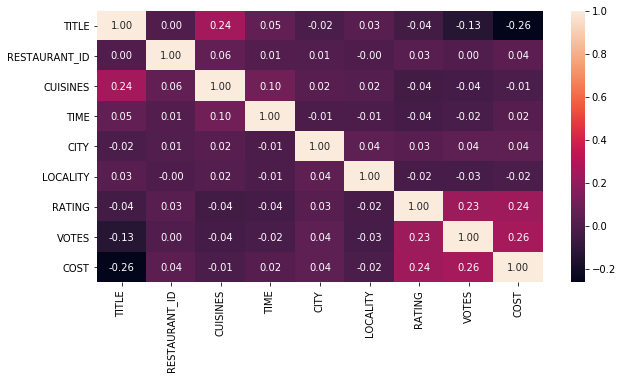

In [26]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

# Data Cleaning

<Figure size 1440x1080 with 0 Axes>

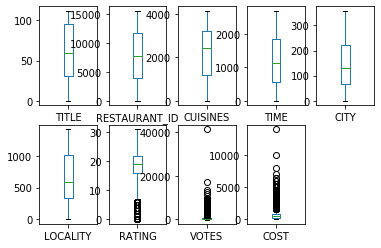

In [27]:
plt.figure(figsize=(20,15))
df.plot(kind='box',subplots=True,layout=(2,5)) 
plt.show()

In [28]:
from scipy.stats import zscore # removing outliers
z=abs(zscore(df))
print(df.shape)
df_final=df.loc[(z<3).all(axis=1)]
print(df_final.shape)
df=df_final

(12690, 9)
(11773, 9)


In [29]:
y=df["COST"]
dfx=df.drop(columns=['COST'], axis=1)

In [30]:
dfx.skew()

TITLE           -0.084354
RESTAURANT_ID    0.005701
CUISINES        -0.217130
TIME             0.342216
CITY             0.313425
LOCALITY         0.340228
RATING           0.164154
VOTES            2.546568
dtype: float64

In [31]:
# handling skewness
from scipy.stats import boxcox
for col in dfx.columns:
    if dfx.skew().loc[col]>0.55:
        dfx[col]=np.log1p(dfx[col])

In [32]:
dfx.skew()

TITLE           -0.084354
RESTAURANT_ID    0.005701
CUISINES        -0.217130
TIME             0.342216
CITY             0.313425
LOCALITY         0.340228
RATING           0.164154
VOTES            0.010162
dtype: float64

In [33]:
dfx.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,31,9438,2627,739,320,285,17,3.912023
1,33,13198,289,1885,67,1046,23,3.433987
2,31,10915,2976,661,67,1101,19,5.402677
3,95,6346,4130,275,222,136,22,3.218876
4,50,15387,1766,615,222,620,19,5.111988


In [34]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
x=ss.fit_transform(dfx)
x=pd.DataFrame(x,columns=dfx.columns)
x.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,-0.878591,0.370672,0.323606,-0.559907,2.104484,-0.917111,-0.486256,-0.766292
1,-0.817814,1.204647,-1.611147,0.971809,-0.870167,0.985625,0.716115,-1.122264
2,-0.878591,0.698273,0.612412,-0.664160,-0.870167,1.123142,-0.085465,0.343732
3,1.066270,-0.315140,1.567376,-1.180079,0.952248,-1.289657,0.515720,-1.282447
4,-0.301210,1.690171,-0.388893,-0.725643,0.952248,-0.079507,-0.085465,0.127269


# Prediction for Food Cost

In [35]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=42)

In [36]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(7887, 8) (3886, 8)
(7887,) (3886,)


In [37]:
maxrscore=0
for r_state in range(42,100):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=r_state)
    reg=linear_model.LinearRegression()
    reg.fit(x_train,y_train)
    y_pred= reg.predict(x_test)
    r2s=r2_score(y_test,y_pred)
    if r2s > maxrscore:
        maxrscore=r2s
        fr_state=r_state
print("max r2 score corresponding to ",fr_state," is ",maxrscore)

max r2 score corresponding to  76  is  0.2756030223276279


In [38]:
parameter = {'kernel':('linear', 'rbf','poly'), 'C':[1, 10]}
svr = SVR()
grid = GridSearchCV( estimator=SVR(), param_grid = parameter)
grid.fit(x, y)
print(grid)
#print(grid.best_score)
print(grid.best_estimator_.kernel)
print(grid.best_params_)
s=grid.best_estimator_.kernel

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf', 'poly')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
rbf
{'C': 10, 'kernel': 'rbf'}


In [39]:
parameter = {'n_neighbors':(3,5,7,9,11), 'weights':['uniform','distance']}
knn = KNeighborsRegressor()
grid = GridSearchCV( estimator=knn, param_grid = parameter)
grid.fit(x, y)
print(grid)
#print(grid.best_score)
print(grid.best_estimator_.n_neighbors)
print(grid.best_estimator_.weights)
print(grid.best_params_)
k=grid.best_estimator_.n_neighbors
w=grid.best_estimator_.weights

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': (3, 5, 7, 9, 11),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
11
distance
{'n_neighbors': 11, 'weights': 'distance'}


In [40]:
KNR=KNeighborsRegressor(n_neighbors=k,weights=w)
SV=SVR(kernel=s)
LR=LinearRegression()
LAR=Lasso()
RR=Ridge()
DT=DecisionTreeRegressor(random_state=fr_state)
RFR=RandomForestRegressor(random_state=fr_state)
ABR=AdaBoostRegressor(random_state=fr_state)
GBR=GradientBoostingRegressor(random_state=fr_state)

In [41]:
models = []
models.append(('KNeighborsRegressor', KNR))
models.append(('SVR', SV))
models.append(('LinearRegression', LR))
models.append(('LassoRegression', LAR))
models.append(('RidgeRegressor', RR))
models.append(('DecisionTreeRegressor', DT))
models.append(('RandomForestRegressor', RFR))
models.append(('AdaBoostRegressor', ABR))
models.append(('GradientBoostingRegressor',GBR))

In [42]:
Model = []
rmse = []
cvs=[]
r2score=[]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=fr_state)
for name,model in models:
    print('***********************',name,'***********************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    y_pred=model.predict(x_test)
    print('\n')
    sc = cross_val_score(model, x, y, cv=10, scoring='r2').mean()
    print('Cross_Val_Score = ',sc)
    cvs.append(sc)
    print('\n')
    print("error:")
    r2s=r2_score(y_test,y_pred)
    print("r2 score is: ",r2s)
    r2score.append(r2s)
    print('\n')
    rmse1=np.sqrt(mean_squared_log_error(y_test,y_pred))
    print("root Mean squared log error: ",rmse1)
    rmse.append(rmse1)
    print('\n')

*********************** KNeighborsRegressor ***********************


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='distance')


Cross_Val_Score =  0.41529538488649587


error:
r2 score is:  0.40892621710508714


root Mean squared log error:  0.5203154706296553


*********************** SVR ***********************


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Cross_Val_Score =  0.16800585485917402


error:
r2 score is:  0.14907086445818074


root Mean squared log error:  0.560191618392595


*********************** LinearRegression ***********************


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


Cross_Val_Score =  0.2575950631017072


error:
r2 score is:  0.2756030223276279


root Mean squared log error:  0.59270

In [43]:
result = pd.DataFrame({'Model': Model, 'Cross_val_score':cvs,'r2_score':r2score,'root_mean_squared_log_error':rmse})
result

,Model,Cross_val_score,r2_score,root_mean_squared_log_error
0,KNeighborsRegressor,0.415295,0.408926,0.520315
1,SVR,0.168006,0.149071,0.560192
2,LinearRegression,0.257595,0.275603,0.592709
3,LassoRegression,0.257629,0.275553,0.591295
4,RidgeRegressor,0.257595,0.275602,0.592694
5,DecisionTreeRegressor,0.406686,0.415327,0.534566
6,RandomForestRegressor,0.692061,0.681434,0.396990
7,AdaBoostRegressor,0.308182,0.325738,0.603218
8,GradientBoostingRegressor,0.657141,0.655225,0.424146


# Saving the best model

In [44]:
from sklearn.externals import joblib

In [45]:
joblib.dump(RFR,'resfood.pkl')

['resfood.pkl']

In [46]:
model=joblib.load('resfood.pkl')

In [47]:
model.predict(x_test.head())

array([384. , 439.5, 176.5, 477.5, 310. ])